Index(['naver_datalab', 'naver_comment_num', 'naver_senti_score',
       'twitter_tweet_num', 'twitter_senti_score', 'covid_num'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 1 to 393
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   naver_datalab        393 non-null    float64
 1   naver_comment_num    393 non-null    int64  
 2   naver_senti_score    393 non-null    int64  
 3   twitter_tweet_num    393 non-null    int64  
 4   twitter_senti_score  393 non-null    int64  
 5   covid_num            393 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 18.6 KB
None


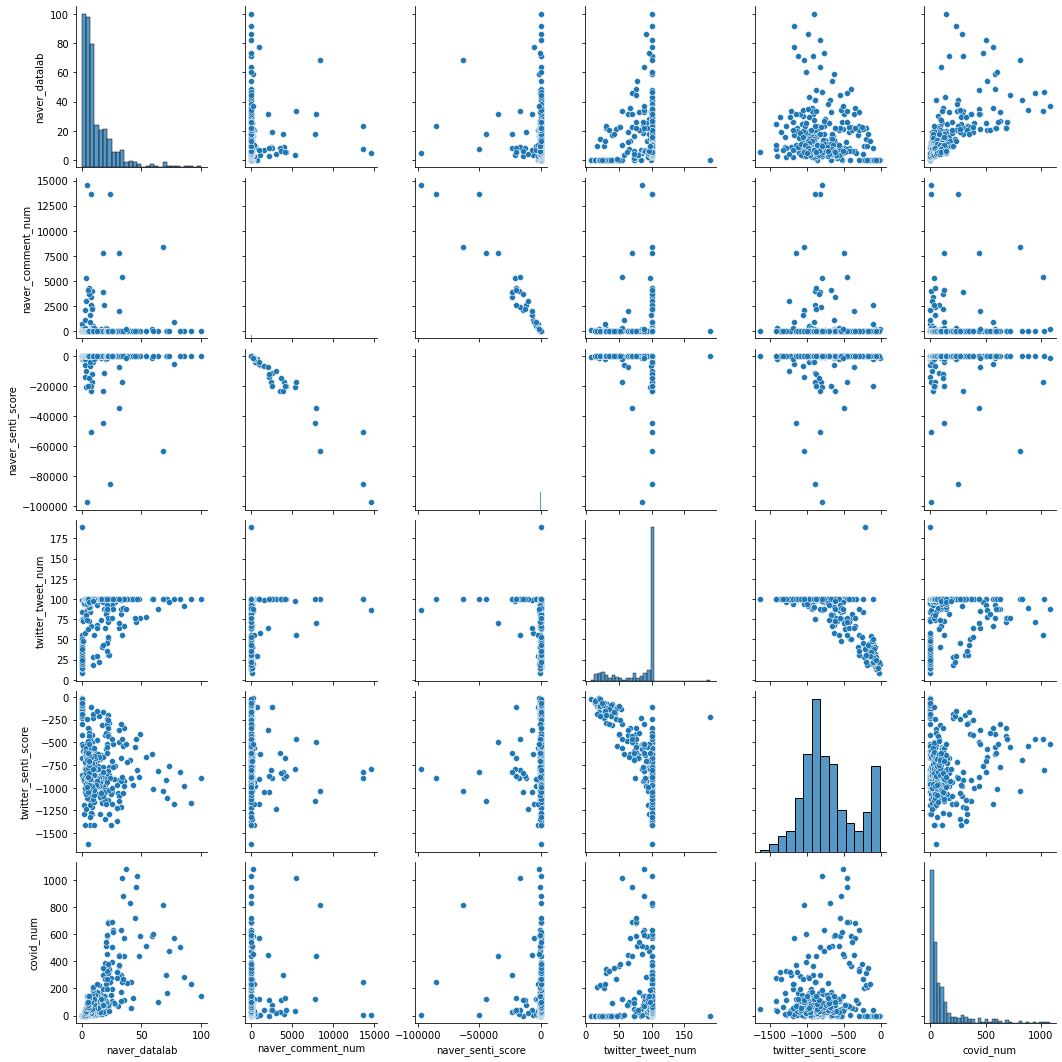

In [49]:

#데이터 특성을 보기 위해 시각화
data=pd.read_csv('corr 최종구글없음.csv',encoding='utf-8',header=0)
data=data[1:]
print(data.columns)

#data=data.apply(pd.to_numeric)
print(data.info())
sns.pairplot(data=data)



In [48]:
corr = data.corr(method = 'pearson')
corr


,naver_datalab,naver_comment_num,naver_senti_score,twitter_tweet_num,twitter_senti_score,covid_num
naver_datalab,1.000000,0.061769,-0.074123,0.252277,-0.289743,0.656255
naver_comment_num,0.061769,1.000000,-0.968993,0.059018,-0.057621,0.096618
naver_senti_score,-0.074123,-0.968993,1.000000,-0.063938,0.060840,-0.094335
twitter_tweet_num,0.252277,0.059018,-0.063938,1.000000,-0.801676,0.077787
twitter_senti_score,-0.289743,-0.057621,0.060840,-0.801676,1.000000,-0.037495
covid_num,0.656255,0.096618,-0.094335,0.077787,-0.037495,1.000000


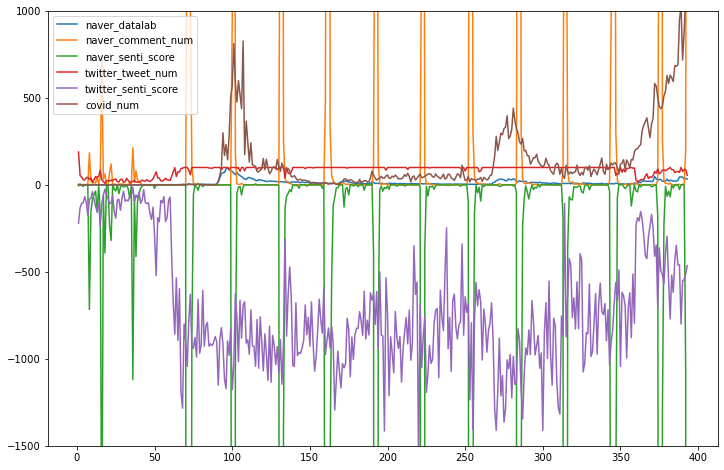

In [65]:
from pylab import rcParams

rcParams['figure.figsize'] = 12, 8
#df.naver_datalab.plot()
#df.covid_num.plot()
data.plot()
plt.ylim(-1500, 1000)

plt.show()

                            OLS Regression Results                            
Dep. Variable:              covid_num   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     295.8
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           9.13e-50
Time:                        17:13:27   Log-Likelihood:                -2497.8
No. Observations:                 393   AIC:                             5000.
Df Residuals:                     391   BIC:                             5007.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.6495      9.173      1.924

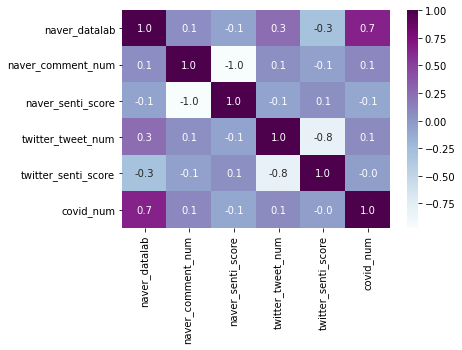

In [50]:

#단순회귀분석에서 유의한 변수
variables = list(data.columns)
pvalues=[]

for variable in variables:
    lm_formula='covid_num ~ '+variable
    lm_model = smf.ols(formula=lm_formula, data=data).fit()
    print(lm_model.summary())
    if lm_model.pvalues[1]<0.05:
        pvalues.append('p-value<0.05')
    else:
        pvalues.append('p-value=>0.05')

print(pd.DataFrame(pvalues,index=variables))

#variable 간의 상관행렬을 Heatmap로 작성
sns.heatmap(data.corr(), annot = True, cmap='BuPu',fmt='.1f')
plt.show()

In [51]:
#전진 선택법을 이용한 다중 회귀 분석
y = data['covid_num']  ## 반응 변수
selected_variables = []  ## 선택된 변수들
sl_enter = 0.05
sv_per_step = []  ## 각 스텝별로 선택된 변수들
adjusted_r_squared = []  ## 각 스텝별 수정된 결정계수
steps = []  ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder)  ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
    ## 선형 모형을 적합한다.
    for col in remainder:
        X = data[selected_variables + [col]]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        pval[col] = model.pvalues[col]
    min_pval = pval.min()
    if min_pval < sl_enter:  ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y, sm.add_constant(data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break
selected_variables_using_forward = selected_variables
print(selected_variables_using_forward)

['covid_num', 'naver_senti_score']


<ipython-input-51-360299f72d6b>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)  ## 변수의 p-value
<ipython-input-51-360299f72d6b>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)  ## 변수의 p-value
<ipython-input-51-360299f72d6b>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)  ## 변수의 p-value


In [53]:
#후진소거법을 이용한 다중 회귀 분석
y = data['covid_num']  ## 반응 변수
selected_variables = variables  ## 초기에는 모든 변수가 선택된 상태
sl_remove = 0.05
sv_per_step = []  ## 각 스텝별로 선택된 변수들
adjusted_r_squared = []  ## 각 스텝별 수정된 결정계수
steps = []  ## 스텝
step = 0
while len(variables) > 0:
    X = sm.add_constant(data[selected_variables])
    p_vals = sm.OLS(y, X).fit().pvalues[1:]  ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max()  ## 최대 p-value
    if max_pval >= sl_remove:  ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y, sm.add_constant(data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break
selected_variables_using_backward = selected_variables
print(selected_variables_using_backward)

['naver_comment_num', 'naver_senti_score', 'twitter_senti_score', 'covid_num']


In [55]:
#단계별선택법을 이용한 다중회귀분석
y = data['covid_num']  ## 반응 변수
selected_variables = []  ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
sv_per_step = []  ## 각 스텝별로 선택된 변수들
adjusted_r_squared = []  ## 각 스텝별 수정된 결정계수
steps = []  ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder)  ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
    ## 선형 모형을 적합한다.
    for col in remainder:
        X = data[selected_variables + [col]]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        pval[col] = model.pvalues[col]
    min_pval = pval.min()
    if min_pval < sl_enter:  ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = data[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y, selected_X).fit().pvalues[1:]  ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove:  ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y, sm.add_constant(data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break
selected_variables_using_stepwise= selected_variables
print(selected_variables_using_stepwise)

['covid_num', 'naver_senti_score']


<ipython-input-55-801ce2414f1e>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)  ## 변수의 p-value
<ipython-input-55-801ce2414f1e>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)  ## 변수의 p-value
<ipython-input-55-801ce2414f1e>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)  ## 변수의 p-value


In [56]:
lm_model_forward = smf.ols('covid_num~ naver_senti_score',data=data).fit()
print(lm_model_forward.summary())
lm_model_backward = smf.ols('covid_num~ naver_comment_num+naver_senti_score+twitter_senti_score',data=data).fit()
print(lm_model_backward.summary())
lm_model_stepwise = smf.ols('covid_num~ naver_senti_score',data=data).fit()
print(lm_model_stepwise.summary())

                            OLS Regression Results                            
Dep. Variable:              covid_num   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.511
Date:                Mon, 21 Dec 2020   Prob (F-statistic):             0.0617
Time:                        17:26:18   Log-Likelihood:                -2606.7
No. Observations:                 393   AIC:                             5217.
Df Residuals:                     391   BIC:                             5225.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           115.2550      9.47